# Time series forecasting of a single feature
**V1: Single-step models**

A comparison between different prediction models

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [189]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

### Import data

In [190]:
data = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
data["datetime"] = pd.to_datetime(data["datetime"], infer_datetime_format=True)
date_time = data["datetime"]

# extract the relevant data
df = pd.DataFrame(data, columns=["power_production_wind_avg", "power_production_solar_avg"])
df = df.rename(columns={"power_production_wind_avg": "wind", "power_production_solar_avg": "solar"})
df.head()

,wind,solar
0,4006.75,0.0
1,3573.75,0.0
2,3145.25,0.0
3,2828.50,0.0
4,2608.75,0.0


In [191]:
date_time.head()

0   2021-01-01 00:00:00+00:00
1   2021-01-01 01:00:00+00:00
2   2021-01-01 02:00:00+00:00
3   2021-01-01 03:00:00+00:00
4   2021-01-01 04:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]

### Take a look at the data

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

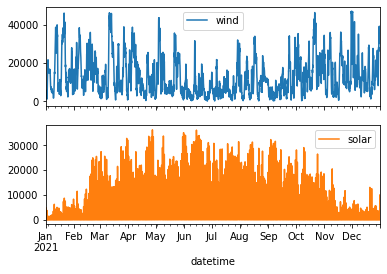

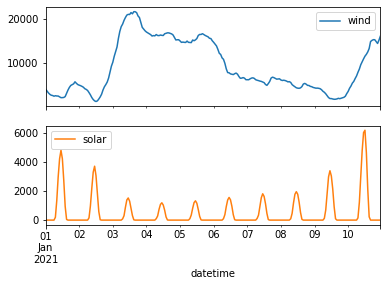

In [192]:
# plot whole year
plot_features = df.copy()
plot_features.index = date_time
plot_features.plot(subplots=True)

# plot first 10 days
plot_features = df[:240].copy()
plot_features.index = date_time[:240]
plot_features.plot(subplots=True)

In [193]:
# Statistics of the dataset
df[["wind","solar"]].describe()

,wind,solar
count,8760.000000,8760.000000
mean,12973.506250,5320.323687
std,9861.446223,8182.894750
min,147.750000,0.000000
25%,5448.875000,0.000000
50%,10200.750000,160.750000
75%,18372.875000,8693.750000
max,46953.250000,36175.250000


### Determining the most important frequencies

Text(0.5, 0, 'Frequency (log scale)')

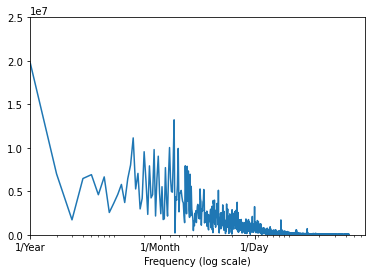

In [194]:
fft = tf.signal.rfft(df["wind"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["wind"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2.5e7)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524], labels=['1/Year', '1/Month', '1/Day'])
plt.xlabel('Frequency (log scale)')

Text(0.5, 0, 'Frequency (log scale)')

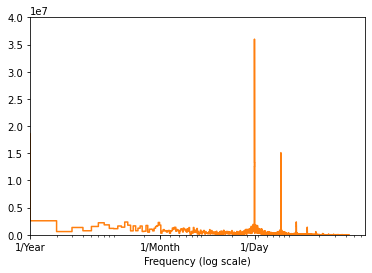

In [195]:
from turtle import color

fft = np.fft.rfft(df["solar"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["solar"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft), 'tab:orange')
plt.xscale('log')
plt.ylim(0, 4e7)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524], labels=['1/Year', '1/Month', '1/Day'])
plt.xlabel('Frequency (log scale)')

### Create periodical time signals

In [196]:
day_s = 24*60*60
year_s = (365.2425)*day_s
timestamp_s = date_time.map(pd.Timestamp.timestamp)

df["day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
df["day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))
df.head()

,wind,solar,day_sin,day_cos,year_sin,year_cos
0,4006.75,0.0,-6.012051e-12,1.000000,0.010881,0.999941
1,3573.75,0.0,2.588190e-01,0.965926,0.011597,0.999933
2,3145.25,0.0,5.000000e-01,0.866025,0.012314,0.999924
3,2828.50,0.0,7.071068e-01,0.707107,0.013031,0.999915
4,2608.75,0.0,8.660254e-01,0.500000,0.013747,0.999905


Text(0.5, 1.0, 'Time of day signal')

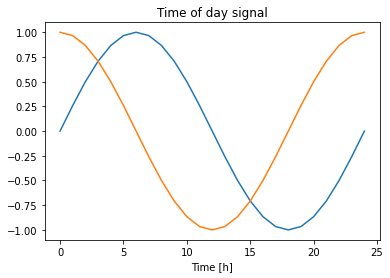

In [197]:
# plotting a day
plt.plot(np.array(df['day_sin'])[:25])
plt.plot(np.array(df['day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Split the data
- 70% training
- 20% validation
- 10% test

In [198]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

In [199]:
train_mean = train_df.mean()
train_std = train_df.std()
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

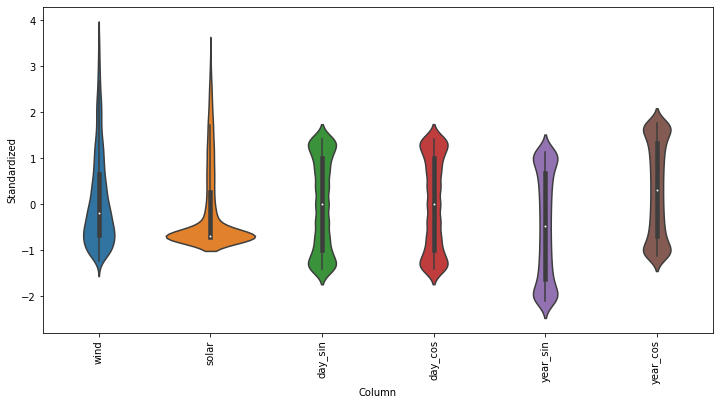

In [200]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Standardized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

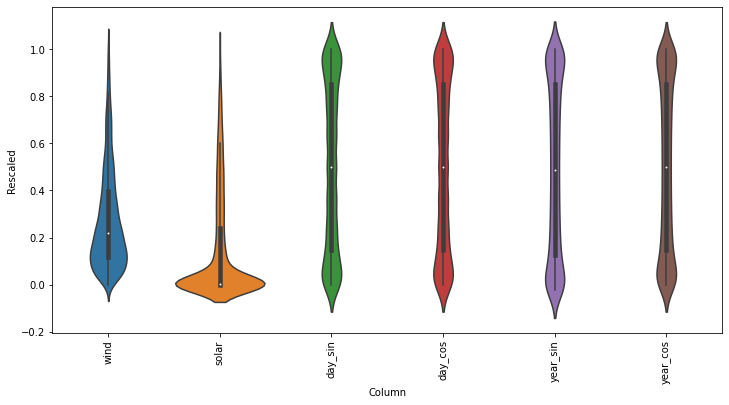

In [201]:
# Alternative: Rescale the data (min-max normalization)
df_scl = (df - train_min) / (train_max - train_min)
df_scl = df_scl.melt(var_name='Column', value_name='Rescaled')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Rescaled', data=df_scl)
_ = ax.set_xticklabels(df.keys(), rotation=90)

What is better?
More info and alternative scalers: https://scikit-learn.org/stable/modules/preprocessing.html

### Data Windowing
#### 1. Indexes and offsets

In [202]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [203]:
w1 = WindowGenerator(input_width=24, label_width=24, shift=24,
                     label_columns=["solar"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['solar']

##### 2. Split

In [204]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [205]:
# Split windows example
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 6)
Inputs shape: (3, 24, 6)
Labels shape: (3, 24, 1)


##### 3. Plot

In [206]:
def plot(self, model=None, plot_col="solar", max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

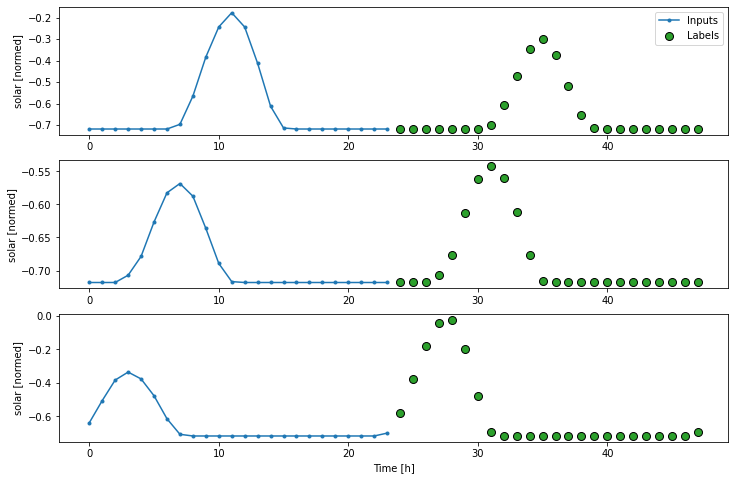

In [207]:
w1.example = example_inputs, example_labels
w1.plot(plot_col="solar")

#### 4. Create `tf.data.Datasets`

In [208]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [209]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [210]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 24, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

### Single step models

Single step models predict one time step in the future, same number of labels and inputs.

In [211]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["solar"])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['solar']

In [212]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [213]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

#### Baseline model
- next value equal to current value
- not trainable

In [214]:
baseline = Baseline(label_index=column_indices["solar"])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_absolute_error: 0.1348


In [215]:
# create a wider window
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["solar"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['solar']

In [216]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


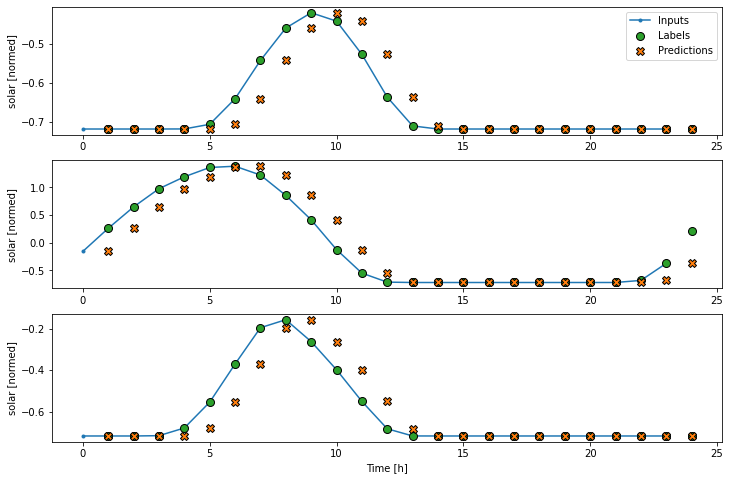

In [217]:
wide_window.plot(baseline)

#### Linear model
- linear transformation
- prediction only depends on one time step

In [218]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [219]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [220]:
# Training procedure

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [221]:
history = compile_and_fit(linear, single_step_window)

IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 668us/step - loss: 0.0458 - mean_absolute_error: 0.1830


In [222]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


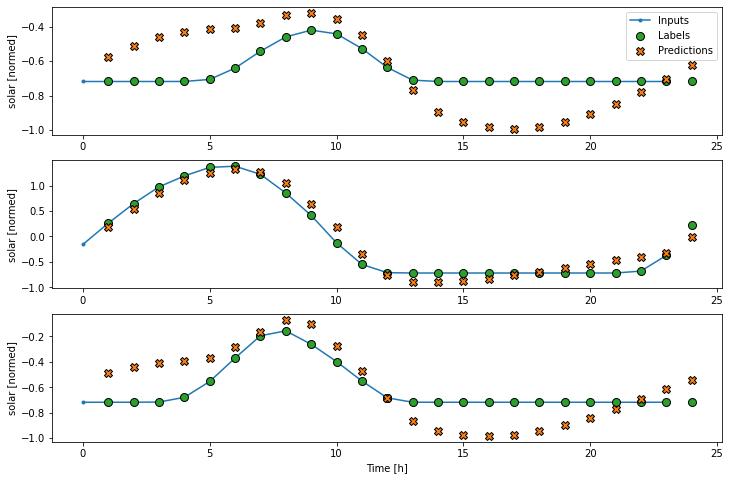

In [223]:
wide_window.plot(linear)

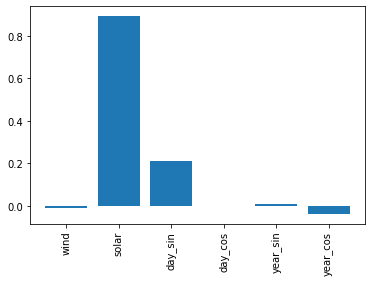

In [224]:
# plot weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Multi-step dense
- Model predicts one time step into the future based on three time steps

In [225]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["solar"])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['solar']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

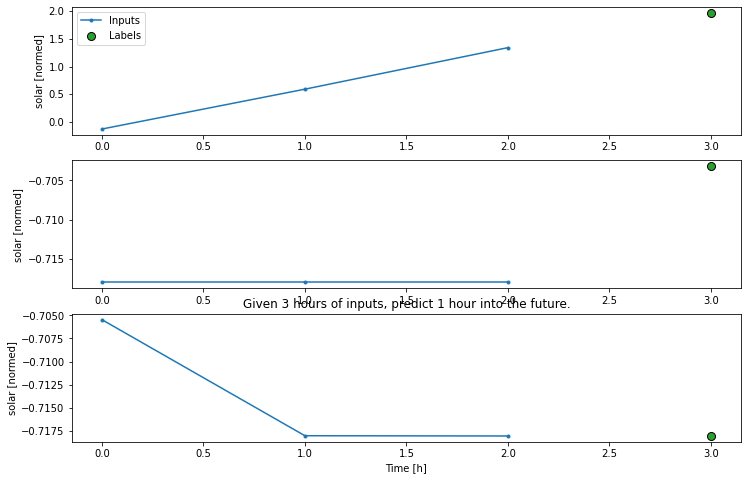

In [226]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [227]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])
])

In [228]:
print("Multi-step dense on `conv_window`:")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Multi-step dense on `conv_window`:
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [229]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

55/55 [==============================] - 0s 687us/step - loss: 0.0142 - mean_absolute_error: 0.0958


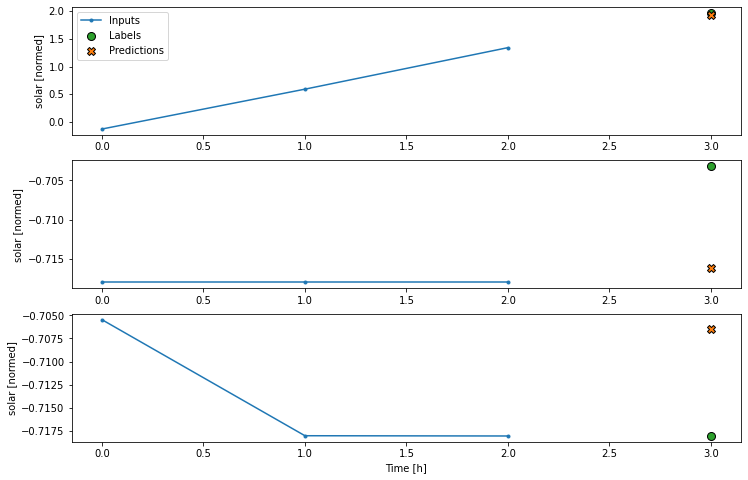

In [230]:
conv_window.plot(multi_step_dense)

#### Convolutional Neural Network
- Same model as `multi_step_dense`, but rewritten as CNN

In [231]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [232]:
print("Conv model on `conv_window`:")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`:
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [233]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

55/55 [==============================] - 0s 670us/step - loss: 0.0069 - mean_absolute_error: 0.0633


Fix that input is shorter that output:

In [234]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["solar"])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['solar']

In [235]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


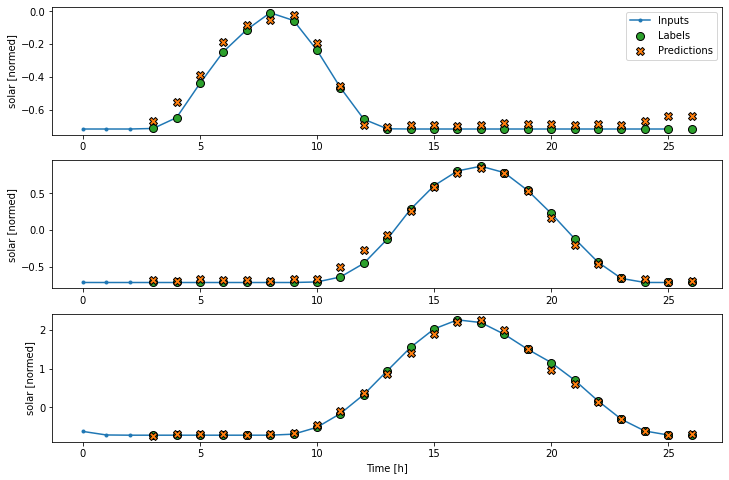

In [236]:
wide_conv_window.plot(conv_model)

#### Recurrent neural network (LSTM)

- If `return-sequences` is `False`: Layer only returns the output of the final time step
- If `return-sequences` is `True`: Layer returns the output of all time steps

In [237]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [238]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [239]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0288


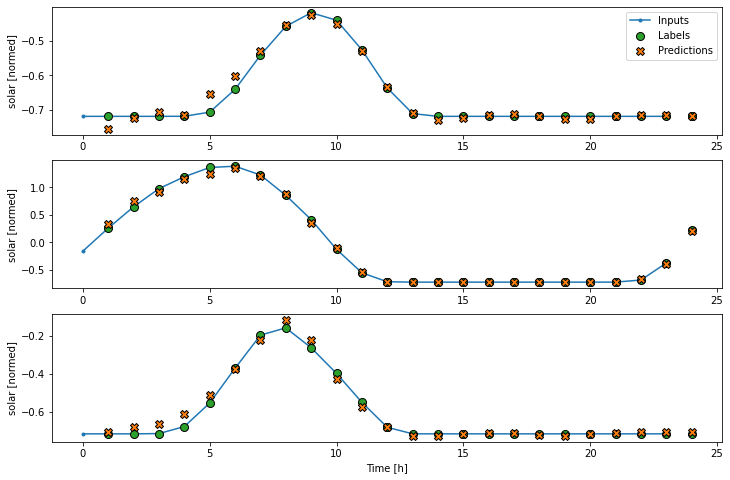

In [240]:
wide_window.plot(lstm_model)

#### Residual connections
- Knowledge that changes in time series are small gets implemented into model structure: The model predicts the value change instead of the value

In [241]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model
    # delete all dimensions from input except solar
    return tf.expand_dims(inputs[:,:,1], -1) + delta

In [242]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

In [243]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', residual_lstm(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [244]:
history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0272


### Performance Comparison

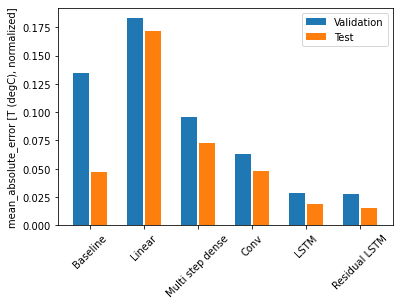

In [245]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [246]:
for name, value in performance.items():
  print(f'{name+":":17s} {value[1]:0.4f}')

Baseline:         0.0467
Linear:           0.1719
Multi step dense: 0.0728
Conv:             0.0482
LSTM:             0.0190
Residual LSTM:    0.0157
